In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.stats import norm
import torch
from torch.distributions import MultivariateNormal
import itertools
from tqdm.notebook import *
import seaborn as sns

### Setup

First we define an environment by uniformly sampling $N$ points with scores $f(x)$ sampled from a GP over the unit square in $\mathbb R^2$. 

We assume a prior mean of $\mu_0=0$, and use an RBF kernel $K$ controled by a parameter $\tau$ (as $\tau\!\!\nearrow$, the smoothness increases). 

In [2]:
K = lambda x, y: np.exp(-1 / (2 * tau ** 2) \
                           * np.linalg.norm(x[:, None] - y[None, :], axis=2) \
                           ** 2)
u0 = lambda x: np.zeros(len(x))
N = 500
tau = 0.1

def make_env():
    pts = np.array([[np.random.uniform(0,1), np.random.uniform(0,1)]
           for i in range(N)])
    scores = np.random.multivariate_normal(u0(pts), K(pts, pts))
    return pts, scores

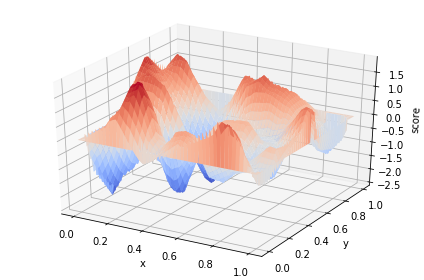

In [3]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.interpolate import griddata

pts, scores = make_env()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
gx, gy = np.meshgrid(np.arange(0, 1, 2e-3), np.arange(0, 1, 2e-3))
Z = griddata(pts, scores, (gx, gy))
ax.plot_surface(gx, gy, np.nan_to_num(Z), cmap=cm.coolwarm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('score')
plt.tight_layout()

plt.show()

In [4]:
def GP(x, X, Y, eps=1e-2, K=K, u0=u0, mu_only=False):
    e = lambda n: eps * np.eye(len(n))
    if not len(X):
        return u0(x) if mu_only else (u0(x), K(x, x) + e(x))
    K_xX, K_XX, K_xx = K(x, X), K(X, X), K(x, x)
    u = K_xX @ np.linalg.inv(e(X) + K_XX) \
            @ (Y - u0(Y))[:, None] + u0(x)[:, None]
    if mu_only: return u.reshape(-1)
    S = K_xx + e(x) - K_xX @ \
            np.linalg.inv(K_XX + e(X)) @ K_xX.T
    return u.reshape(-1), S

def fit_kernel(X, Y, epochs=1000, lr=1e-3, eps=1e-2):
    tau = torch.tensor(1., requires_grad=True)
    K = lambda x, y: torch.exp(-1 / (2 * tau ** 2) * torch.tensor(
            np.linalg.norm(x[:, None] - y[None, :], axis=2) ** 2))
    opt = torch.optim.Adam([tau], lr=lr)
    for i in range(epochs):
        opt.zero_grad()
        cov = K(X, X) + eps * torch.eye(len(X))
        loss = -MultivariateNormal(torch.zeros(len(X)), cov).log_prob(torch.tensor(Y))
        loss.backward()
        opt.step()
    return (lambda x, y: K(x, y).detach().numpy())

In [5]:
def run_trial(agent, H):
    X, Y = make_env()
    results = []
    seen = []
    for i in range(H):
        i = agent(X, np.array(seen), np.array(results), H - i)
        seen.append(X[i])
        results.append(Y[i])
        X = np.delete(X, i, axis=0)
        Y = np.delete(Y, i, axis=0)
    return sum(results), max(results)

def run_agent(agent, H, n):
    results = np.array([run_trial(agent, H) for _ in trange(n)])
    means = tuple(results.mean(axis=0))
    stds = tuple(results.std(axis=0) / np.sqrt(n))
    return dict(sum=dict(avg=means[0], se=stds[0]), max=dict(avg=means[1], se=stds[1]))

### Algorithms
Each agent takes $(X, X_{obs}, Y_{obs}, H)$

##### Parameters
$X$: unseen sequences<br>
$X_{obs}$: seen sequences $x$<br>
$Y_{obs}$: seen sequence scores $f(x)$<br>
$H$: remaining time horizon

##### Returns
$i$: index of choice in $X$

<hr>

Test with <code>run_agent(agent, H, n)</code>. Runs agent for $H$ sequential time steps in the previously constructed environment. Returns the sum and maximum of observed scores, across $n$ trials, with means and standard errors.

In [6]:
def random(X, X_obs, Y_obs, H):
    return np.random.choice(len(X))

<code>greedy</code> takes $\arg\max_x\mathbb E[f(x)\mid\mathcal D]$ (for $\mathcal D=\{(X_{\scriptscriptstyle obs}^{\scriptscriptstyle(i)},Y_{\scriptscriptstyle obs}^{\scriptscriptstyle(i)})\ldots\}$).

In [7]:
def greedy(X, X_obs, Y_obs, H):
    mu = GP(X, X_obs, Y_obs, mu_only=True)
    return np.argmax(mu)

<code>egreedy</code> is <code>random</code> with probability $\varepsilon$ and <code>greedy</code> otherwise.

In [8]:
eps = 0.2
def egreedy(X, X_obs, Y_obs, H):
    if np.random.random() < eps:
        return np.random.choice(len(X))
    else:
        mu = GP(X, X_obs, Y_obs, mu_only=True)
        return np.argmax(mu)

<code>gp_ucb</code> 
uses a UCB acquisition function of $u(x)=\mu+\sigma\sqrt\beta$ for $\mu=\mathbb E[f(x)\mid\mathcal D]$ and $\sigma^2=\operatorname{Var}[f(x)\mid\mathcal D]$.

In [9]:
beta = 1.
def gp_ucb(X, X_obs, Y_obs, H):
    mu, sigma = GP(X, X_obs, Y_obs)
    return np.argmax(mu + np.sqrt(beta) * np.diag(sigma))

For <code>gp_ts</code>, at each timestep we Thompson sample $\theta\sim p(f\mid\mathcal D)$, and the select $\arg\max\theta$.

In [10]:
def gp_ts(X, X_obs, Y_obs, H):
    mu, sigma = GP(X, X_obs, Y_obs)
    Y_samp = np.random.multivariate_normal(mu, sigma)
    return np.argmax(Y_samp)

For <code>ei_max</code> we use the acquisition function $\operatorname{EI}(x)$, defined as the expected improvement in the maximum. 
Suppose at any step the current best observation is $x^*$ with $y^* = f(x^*)$.
We can explicitly compute $$\operatorname{EI}(x)=(\mu-y^*)\Phi\left(\mu-y^*\over\sigma\right)+\sigma\phi\left(\mu-y^*\over\sigma\right)$$
for $\mu=\mathbb E[f(x)\mid\mathcal D],\;\sigma^2=\operatorname{Var}[f(x)\mid\mathcal D]$ and $\phi,\;\Phi$ the pdf and cdf respectively of the unit normal. This acquisition function myopically maximizes the **max** metric.

In [11]:
def ei_max(X, X_obs, Y_obs, H):
    mu, sigma = GP(X, X_obs, Y_obs)
    ys = np.max(Y_obs) if len(Y_obs) else 0
    Z = (mu - ys) / np.diag(sigma)
    EI = (mu - ys) * norm.cdf(Z) + np.diag(sigma) * norm.pdf(Z)
    return np.argmax(EI)

<code>nonmyopic_sum</code> nonmyopically optimizes the **sum** of observed scores across the remaining timesteps. Denoting the final sum of scores $R$, we then have the acquisition function
$$\begin{align*}u(x) 
&=\mathbb E[R\mid x,\mathcal D, H]\\
&=\mathbb E[f(x)\mid\mathcal D]+
\int_y\max_{x'}\mathbb E[R\mid x',\mathcal D\cup\{(x,y)\},H-1]\,p(f(x)=y\mid\mathcal D)\,\mathrm dy\end{align*}$$
where $R=0$ after the last step when $H=0$. To approximate the integral, we can use MC sampling of $y\sim p(f(x)\mid\mathcal D)$. Then, we must approximate $\max_{x'}\mathbb E[R\mid x',\mathcal D\cup\{(x,y)\},H-1]$. We do this myopically, adapting the techniques in (Jiang et al., 2017, Efficient Nonmyopic Active Search), noting 
$$\max_{x'}\mathbb E[R\mid x',\mathcal D\cup\{(x,y)\},H-1]\approx\sum_{H-1}{~^\llap{~^{\large '}~}}\mathbb E[f(x')\mid\mathcal D\cup\{(x,y)\}]$$ where $\sum'_k$ sums over the $k$ values $x'$ not in $\mathcal D$ maximizing the summand.

We are then left with the computable utility
$$u(x) \approx \mathbb E[f(x)\mid\mathcal D]+\frac1M\sum_{i=1}^M\sum_{H-1}{~^\llap{~^{\large'}~}}\mathbb E[f(x')\mid\mathcal D\cup\{(x,y_i)\}]$$ for each $y_i\sim p(f(x)\mid\mathcal D)$ and a fixed precision hyperparameter $M$. We interpret these two terms as corresponding to exploitation and exploration respectively. We can efficiently compute the expectation in the second term by only locally refitting our GP model, ignoring points with less than some fixed nominal covariance with $x$.

In [12]:
M = 10
nominal_cov = 1e-2
def nonmyopic_sum(X, X_obs, Y_obs, H):
    mu, sigma = GP(X, X_obs, Y_obs)
    u = np.zeros(len(X))
    yi = np.random.normal([mu] * M, [np.sqrt(np.diag(sigma))] * M)
    for i in range(len(X)):
        diff = K(X[i:i+1], X).reshape(-1) > nominal_cov
        mu_ = np.array(mu)
        for y in yi[:, i]:
            mu_local = GP(X[diff], np.concatenate((X_obs.reshape(-1, 2), X[i:i+1]), axis=0), 
                         np.concatenate((Y_obs, np.array([y])), axis=0), mu_only=True)
            mu_[diff] = mu_local
            u[i] += np.sort(np.delete(mu_, i, axis=0))[len(mu_) - H:].sum()
        u[i] /= M
    u += mu
    return np.argmax(u)

In [13]:
run_agent(random, H=50, n=300)

{'sum': {'avg': -0.6513711673914598, 'se': 0.7900962512732416},
 'max': {'avg': 2.07269188385221, 'se': 0.03109093484715338}}

In [14]:
run_agent(greedy, H=50, n=150)

{'sum': {'avg': 50.76009754062597, 'se': 1.5586069711630157},
 'max': {'avg': 2.0983462606621077, 'se': 0.046791128584077045}}

In [15]:
run_agent(egreedy, H=50, n=150)

{'sum': {'avg': 51.28866265014068, 'se': 1.398852031728157},
 'max': {'avg': 2.3193676154572818, 'se': 0.04287831430451573}}

In [16]:
run_agent(gp_ucb, H=50, n=100)

{'sum': {'avg': 59.75254610180689, 'se': 2.1021051380305145},
 'max': {'avg': 2.4030612165472984, 'se': 0.04932297685545457}}

In [17]:
run_agent(gp_ts, H=50, n=50)

{'sum': {'avg': 37.031113425396846, 'se': 2.6360442526413506},
 'max': {'avg': 2.420171371433324, 'se': 0.0726371567490927}}

In [18]:
run_agent(ei_max, H=50, n=100)

{'sum': {'avg': 15.8370342371441, 'se': 1.290043406250375},
 'max': {'avg': 2.514377278195081, 'se': 0.05361467392897391}}

In [19]:
run_agent(nonmyopic_sum, H=50, n=10)

{'sum': {'avg': 56.28558521294642, 'se': 7.286091313458131},
 'max': {'avg': 2.7679220080301628, 'se': 0.23567857167105338}}